# Federated Learning for Text Generation

In [1]:
# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

# !pip install --quiet tensorflow_federated
# !pip install --quiet tf-nightly

# NOTE: Jupyter requires a patch to asyncio.
# !pip install --upgrade nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [60]:
from __future__ import absolute_import, division, print_function

import collections
import functools
import os
import six
import time
import glob
from datetime import datetime
import pickle

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

# Test the TFF is working:
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
%load_ext tensorboard

# 1. Pre-train a centralized model on Trajnet dataset

http://trajnet.stanford.edu/


## 1.1 Load Benchmarking Data

In [5]:
path = 'benchmarking_data/Train/train/stanford/*.txt' 

samples_bm = {}
last_sample_bm_keys = {}

for filename in glob.iglob(path):
    for line in open(filename):
        data = line.strip('\n').split(' ')
        rid = data[1]
        x1 = float(data[2])/20.
        x2 = float(data[3])/20. - 1.
        if rid in samples_bm.keys():
            last_key = last_sample_bm_keys[rid]
            if(last_key not in samples_bm[rid]):
                samples_bm[rid][last_key] = []
            samples_bm[rid][last_key].append((x1, x2))
            if len(samples_bm[rid][last_key]) == 20:
                last_sample_bm_keys[rid]+=1
        else:
            samples_bm.update({rid: {}})
            samples_bm[rid].update({0: [(x1, x2)]})
            last_sample_bm_keys.update({rid: 0})

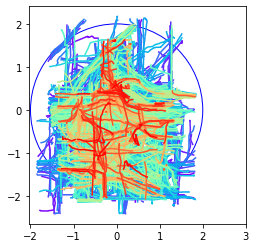

In [6]:
colors = cm.rainbow(np.linspace(0, 1, len(samples_bm.keys())))
cnt = 0


plt.figure()
for v in samples_bm.values():
    for traj in v.values():
        if (len(traj) > 0):
            x, y = zip(*traj)
        plt.plot(x, y, color=colors[cnt])
    cnt += 1
    
ax = plt.gca()
circle2 = plt.Circle((0, 0), 2, color='b', fill=False)
ax.add_artist(circle2)
plt.axis('square')
plt.show( )

In [7]:
# Count samples in dataset
count_traj = sum(len(v) for v in samples_bm.values())

print(count_traj)

8985


In [8]:
# Check the length of sequences
for k,v in samples_bm.items():
    for kk, vv in v.items():
             if len(vv) != 20:
                print(len(v),len(vv))

## 1.2 Create Labels

In [9]:
TRAIN_RATIO = 0.2
VAL_RATIO = 1 - TRAIN_RATIO
PAST_HISTORY = 12
FUTURE_TARGET = 8
TIME_STEP = 0.1

BATCH_SIZE = 16
BUFFER_SIZE = 100

In [10]:
def tuple_list_data(dataset, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(dataset.values())
    for i in range(start_index, end_index):
        data.append(np.asarray(list_dataset)[i][:history_size])
        labels.append(np.asarray(list_dataset)[i][history_size:])
        
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

## 1.3 Create tf Dataset

In [11]:
count = 1
x_train = np.zeros((1,PAST_HISTORY,2))
y_train = np.zeros((1,FUTURE_TARGET,2))
x_val = np.zeros((1,PAST_HISTORY,2))
y_val = np.zeros((1,FUTURE_TARGET,2))

for v in samples_bm.values():
    tot_samples = len(v)
    train_split = round(TRAIN_RATIO * tot_samples)
    x_train_tmp, y_train_tmp = tuple_list_data(v, 0, train_split, PAST_HISTORY)
    x_val_tmp, y_val_tmp = tuple_list_data(v, train_split, tot_samples, PAST_HISTORY)
    x_train = np.concatenate([x_train, x_train_tmp], axis=0)
    y_train = np.concatenate([y_train, y_train_tmp], axis=0)
    x_val = np.concatenate([x_val, x_val_tmp], axis=0)
    y_val = np.concatenate([y_val, y_val_tmp], axis=0)
    

In [12]:
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train, 49, dtype='float32', padding='post', value=-10)
y_train_padded = tf.keras.preprocessing.sequence.pad_sequences(y_train, 49, dtype='float32', padding='post', value=-10)
x_val_padded = tf.keras.preprocessing.sequence.pad_sequences(x_val, 49, dtype='float32', padding='post', value=-10)
y_val_padded = tf.keras.preprocessing.sequence.pad_sequences(y_val, 49, dtype='float32', padding='post', value=-10)

In [13]:
train_set = tf.data.Dataset.from_tensor_slices((x_train_padded, y_train_padded))
train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_set = tf.data.Dataset.from_tensor_slices((x_val_padded, y_val_padded))
val_set = val_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

## 1.4 Custom Loss Function (todo)

In [14]:
def r3_bivariate_gaussian_loss(true, pred):
    """
    Rank 3 bivariate gaussian loss function
    Returns results of eq # 24 of http://arxiv.org/abs/1308.0850
    :param true: truth values with at least [mu1, mu2, sigma1, sigma2, rho]
    :param pred: values predicted from a model with the same shape requirements as truth values
    :return: the log of the summed max likelihood
    """
    x_coord = true[:, :, 0]
    y_coord = true[:, :, 1]
    mu_x = pred[:, :, 0]
    mu_y = pred[:, :, 1]

    # exponentiate the sigmas and also make correlative rho between -1 and 1.
    # eq. # 21 and 22 of http://arxiv.org/abs/1308.0850
    # analogous to https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/model.py#L326
    sigma_x = K.exp(K.abs(pred[:, :, 2]))
    sigma_y = K.exp(K.abs(pred[:, :, 3]))
    rho = K.tanh(pred[:, :, 4]) * 0.1  # avoid drifting to -1 or 1 to prevent NaN, you will have to tweak this multiplier value to suit the shape of your data

    norm1 = K.log(1 + K.abs(x_coord - mu_x))
    norm2 = K.log(1 + K.abs(y_coord - mu_y))

    variance_x = K.softplus(K.square(sigma_x))
    variance_y = K.softplus(K.square(sigma_y))
    s1s2 = K.softplus(sigma_x * sigma_y)  # very large if sigma_x and/or sigma_y are very large

    # eq 25 of http://arxiv.org/abs/1308.0850
    z = ((K.square(norm1) / variance_x) +
         (K.square(norm2) / variance_y) -
         (2 * rho * norm1 * norm2 / s1s2))  # z → -∞ if rho * norm1 * norm2 → ∞ and/or s1s2 → 0
    neg_rho = 1 - K.square(rho)  # → 0 if rho → {1, -1}
    numerator = K.exp(-z / (2 * neg_rho))  # → ∞ if z → -∞ and/or neg_rho → 0
    denominator = (2 * np.pi * s1s2 * K.sqrt(neg_rho)) + epsilon()  # → 0 if s1s2 → 0 and/or neg_rho → 0
    pdf = numerator / denominator  # → ∞ if denominator → 0 and/or if numerator → ∞
    return K.log(K.sum(-K.log(pdf + epsilon())))  # → -∞ if pdf → ∞

## 1.5 Pre-train a Non Federated LSTM

In [15]:
print(train_set)

<RepeatDataset shapes: ((None, 49, 2), (None, 49, 2)), types: (tf.float32, tf.float32)>


In [16]:
print ('Single window of past history : {}'.format(x_train_padded[0].shape))
print ('\n Target trajectory to predict : {}'.format(y_train_padded[0].shape))

Single window of past history : (49, 2)

 Target trajectory to predict : (49, 2)


In [17]:
tf.keras.backend.set_floatx('float32')

In [18]:
EMBEDDING_SIZE = 32
DROP_RATE = 0.3
NUM_OUTPUTS = 2

def create_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-10.,input_shape=x_train_padded.shape[-2:]),
    tf.keras.layers.LSTM(EMBEDDING_SIZE,
                         return_sequences=True,
                         input_shape=x_train_padded.shape[-2:]),
    tf.keras.layers.Dense(NUM_OUTPUTS)
    ])
#     tf.keras.layers.Dropout(DROP_RATE),



In [19]:
model = create_model()

for x, y in val_set.take(1):
    print(model.predict(x).shape)

(16, 49, 2)


In [49]:
EVALUATION_INTERVAL = 50
EPOCHS = 200  
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

simple_lstm_model = create_model()
simple_lstm_model.compile(optimizer='adam',
        loss='mean_absolute_error')
simple_lstm_model.fit(train_set, epochs=EPOCHS,
              steps_per_epoch=EVALUATION_INTERVAL,
              validation_data=val_set, validation_steps=50,
              callbacks=[tensorboard_callback])

# Note: with the regularization loss, it's normal that the validation loss is smaller than the training loss!

Train for 50 steps, validate for 50 steps
Epoch 1/200
50/50 [==============================] - 8s 160ms/step - loss: 0.8816 - val_loss: 0.8162
Epoch 2/200
50/50 [==============================] - 2s 31ms/step - loss: 0.7387 - val_loss: 0.6385
Epoch 3/200
50/50 [==============================] - 2s 34ms/step - loss: 0.4996 - val_loss: 0.3611
Epoch 4/200
50/50 [==============================] - 2s 32ms/step - loss: 0.2856 - val_loss: 0.2223
Epoch 5/200
50/50 [==============================] - 1s 30ms/step - loss: 0.2130 - val_loss: 0.1972
Epoch 6/200
50/50 [==============================] - 1s 28ms/step - loss: 0.2000 - val_loss: 0.1877
Epoch 7/200
50/50 [==============================] - 2s 31ms/step - loss: 0.1861 - val_loss: 0.1976
Epoch 8/200
50/50 [==============================] - 1s 29ms/step - loss: 0.1863 - val_loss: 0.1740
Epoch 9/200
50/50 [==============================] - 2s 30ms/step - loss: 0.1703 - val_loss: 0.1648
Epoch 10/200
50/50 [==============================] - 2s 

Epoch 80/200
50/50 [==============================] - 1s 30ms/step - loss: 0.0284 - val_loss: 0.0283
Epoch 81/200
50/50 [==============================] - 1s 29ms/step - loss: 0.0275 - val_loss: 0.0293
Epoch 82/200
50/50 [==============================] - 1s 29ms/step - loss: 0.0284 - val_loss: 0.0270
Epoch 83/200
50/50 [==============================] - 2s 31ms/step - loss: 0.0280 - val_loss: 0.0329
Epoch 84/200
50/50 [==============================] - 2s 30ms/step - loss: 0.0330 - val_loss: 0.0285
Epoch 85/200
50/50 [==============================] - 1s 27ms/step - loss: 0.0266 - val_loss: 0.0266
Epoch 86/200
50/50 [==============================] - 1s 25ms/step - loss: 0.0278 - val_loss: 0.0273
Epoch 87/200
50/50 [==============================] - 1s 27ms/step - loss: 0.0256 - val_loss: 0.0266
Epoch 88/200
50/50 [==============================] - 1s 27ms/step - loss: 0.0279 - val_loss: 0.0262
Epoch 89/200
50/50 [==============================] - 1s 27ms/step - loss: 0.0251 - val_los

50/50 [==============================] - 1s 26ms/step - loss: 0.0226 - val_loss: 0.0220
Epoch 161/200
50/50 [==============================] - 1s 24ms/step - loss: 0.0220 - val_loss: 0.0218
Epoch 162/200
50/50 [==============================] - 1s 26ms/step - loss: 0.0225 - val_loss: 0.0217
Epoch 163/200
50/50 [==============================] - 1s 25ms/step - loss: 0.0203 - val_loss: 0.0220
Epoch 164/200
50/50 [==============================] - 1s 26ms/step - loss: 0.0221 - val_loss: 0.0217
Epoch 165/200
50/50 [==============================] - 1s 24ms/step - loss: 0.0205 - val_loss: 0.0217
Epoch 166/200
50/50 [==============================] - 1s 27ms/step - loss: 0.0215 - val_loss: 0.0219
Epoch 167/200
50/50 [==============================] - 1s 26ms/step - loss: 0.0219 - val_loss: 0.0224
Epoch 168/200
50/50 [==============================] - 1s 27ms/step - loss: 0.0216 - val_loss: 0.0214
Epoch 169/200
50/50 [==============================] - 1s 24ms/step - loss: 0.0212 - val_loss: 0

In [50]:
from tensorflow.keras.models import load_model

simple_lstm_model.save('pretrained_lstm.h5')  # creates a HDF5 file 'my_model.h5'
#del simple_lstm_model  # deletes the existing model

In [53]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 8743), started 1 day, 3:25:43 ago. (Use '!kill 8743' to kill it.)

In [20]:
from mpl_toolkits.mplot3d import Axes3D

def create_time_steps(length):
    return list(range(-length, 0))

In [21]:
def multi_step_plot(history, true_future, prediction):

    history=np.array(history[history!=-10]).reshape([-1, 2])
    prediction=np.array(prediction[true_future!=-10]).reshape([-1,2])
    true_future=np.array(true_future[true_future!=-10]).reshape([-1, 2])
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.set_xlim([-10,10])
    ax.set_ylim([-2,2])
    
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, history[:, 0], 'b', label='History_x')
    plt.plot(num_in, history[:, 1], 'b', label='History_y')
    plt.plot(np.arange(num_out), true_future, 'bo-',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), prediction, 'ro',
                 label='Predicted Future')
        plt.legend(loc='upper left')
        plt.show()

In [22]:
def multi_step_plot_3D(history, true_future, prediction):
    history=np.array(history[history!=-10]).reshape([-1, 2])
    prediction=np.array(prediction[true_future!=-10]).reshape([-1,2])
    true_future=np.array(true_future[true_future!=-10]).reshape([-1, 2])
    
    fig = plt.figure(figsize=(12, 6))
    ax = Axes3D(fig)
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-10,10])
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    ax.plot3D(np.array(history[:, 0]), np.array(history[:, 1]), num_in, 'bo-', label='History')
    ax.plot3D(np.array(true_future[:,0]), np.array(true_future[:,1]), np.arange(num_out), 'bo',
           label='True Future')
    if prediction.any():
        ax.plot3D(np.array(prediction[:,0]), np.array(prediction[:,1]), np.arange(num_out), 'ro',
                 label='Predicted Future')
        plt.legend(loc='upper left')
        plt.show()

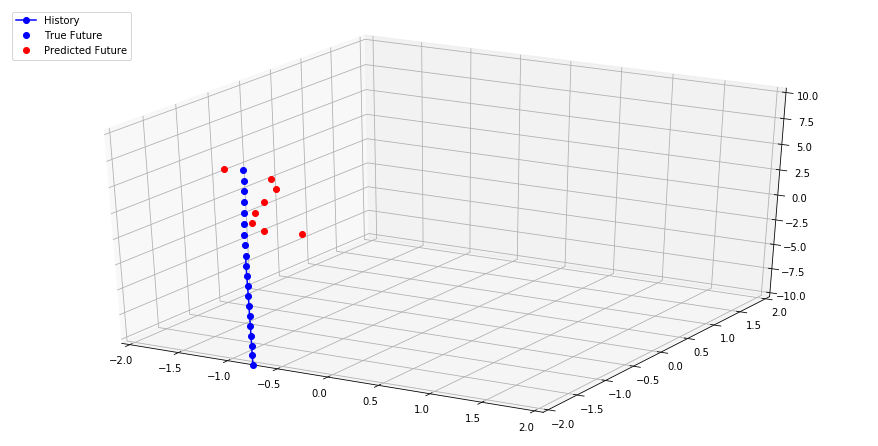

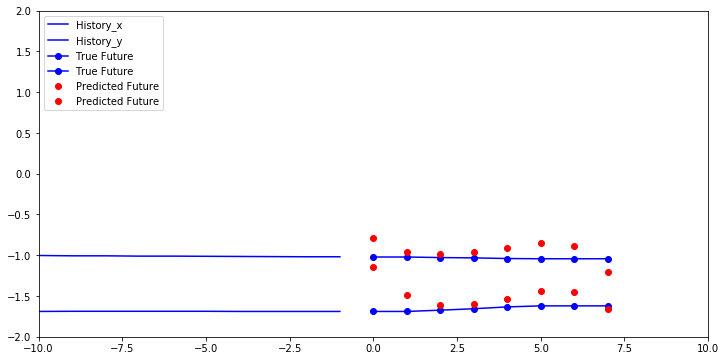

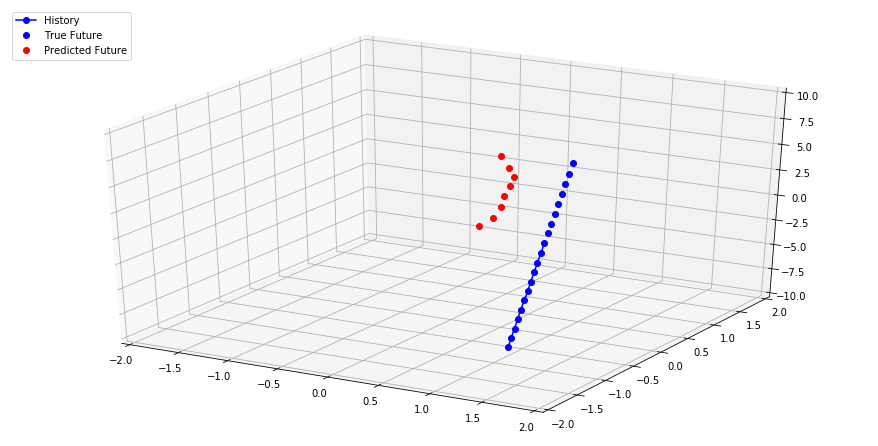

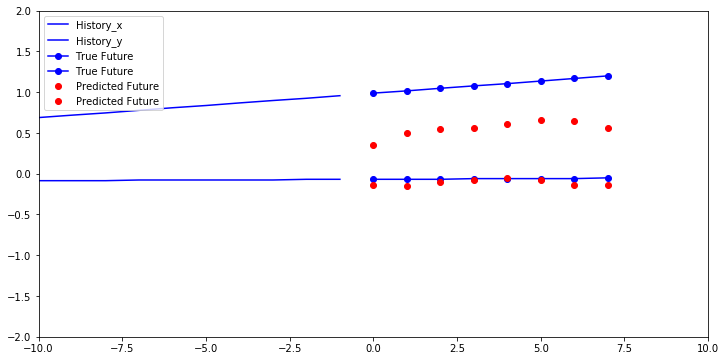

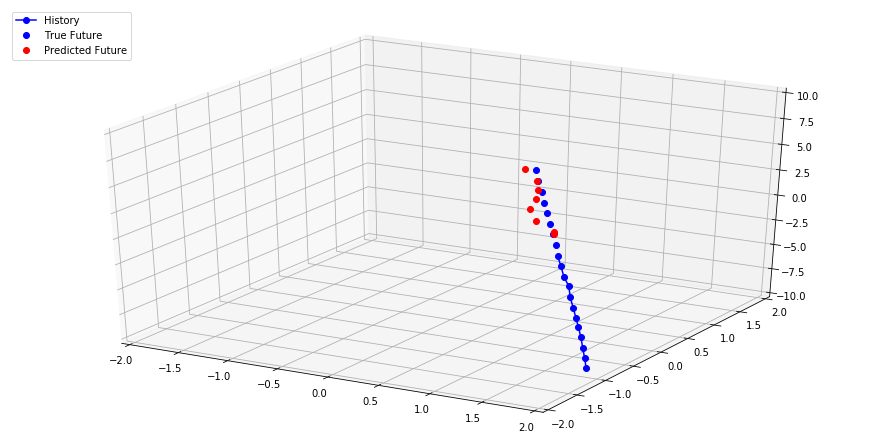

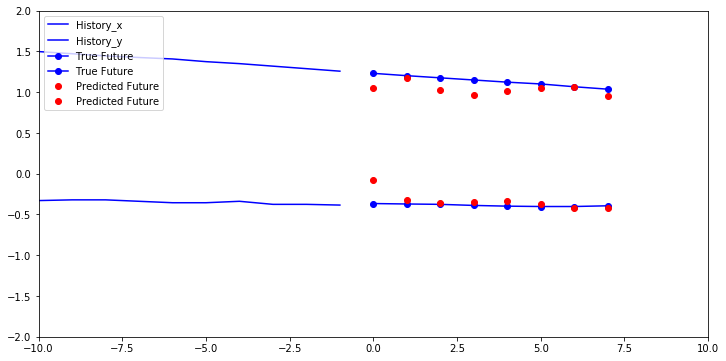

In [23]:
# Stanford validation set
for x, y in val_set.take(3):
    multi_step_plot_3D(history=x[0], true_future=y[0], prediction=simple_lstm_model.predict(x)[0])
    multi_step_plot(history=x[0], true_future=y[0], prediction=simple_lstm_model.predict(x)[0])

# 2. Client-partioned Federated Learning from Trajectory Data


## 2.1 Load Distributed Data

In [23]:
path = '../data/avoidance_20200127_1615**.dat'#'../data/[!G_][!flocking]**.dat' #foraging_20191211_213418.dat' #foraging**.dat'

samples = {}
last_sample_keys = {}

for filename in glob.iglob(path):
    print(filename)
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            rid = data[0]
            x1 = float(data[3])
            x2 = float(data[4])
            if rid in samples.keys():
                last_key = last_sample_keys[rid]
                if(last_key not in samples[rid]):
                    samples[rid][last_key] = []
                samples[rid][last_key].append((x1, x2))
                if len(samples[rid][last_key]) == 99:
                    del samples[rid][last_key][98]
                    last_sample_keys[rid]+=1
            else:
                samples.update({rid: {}})
                samples[rid].update({0: [(x1, x2)]})
                last_sample_keys.update({rid: 0})
        else:
            last_key = last_sample_keys[rid] 
            if(last_key in samples[rid] and len(samples[rid][last_key]) != 0):
                last_sample_keys[rid]+=1

../data/avoidance_20200127_161433.dat
../data/avoidance_20200127_161605.dat
../data/avoidance_20200127_161547.dat
../data/avoidance_20200127_161647.dat
../data/avoidance_20200127_161625.dat
../data/avoidance_20200127_161645.dat
../data/avoidance_20200127_161708.dat
../data/avoidance_20200127_161735.dat
../data/avoidance_20200127_161434.dat
../data/avoidance_20200127_161454.dat
../data/avoidance_20200127_161455.dat
../data/avoidance_20200127_161630.dat
../data/avoidance_20200127_161516.dat
../data/avoidance_20200127_161523.dat
../data/avoidance_20200127_161439.dat
../data/avoidance_20200127_161518.dat
../data/avoidance_20200127_161652.dat
../data/avoidance_20200127_161540.dat
../data/avoidance_20200127_161609.dat
../data/avoidance_20200127_161626.dat
../data/avoidance_20191211_213437.dat
../data/avoidance_20191211_213438.dat
../data/avoidance_20191211_213442.dat
../data/avoidance_20200127_161603.dat
../data/avoidance_20200127_161740.dat
../data/avoidance_20200127_161733.dat
../data/avoi

## 2.3 Visualize Data

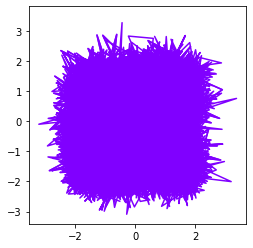

In [25]:
TIME_STEP = 0.1

colors = cm.rainbow(np.linspace(0, 1, len(samples.keys())))
cnt = 0

plt.figure()
for v in samples.values():
    for traj in v.values():
        if (len(traj) > 0):
            x, y = zip(*traj)
        plt.plot(x, y, color=colors[cnt])
    cnt += 1
    break
    
ax = plt.gca()
circle2 = plt.Circle((0, 0), 2, color='b', fill=False)
ax.add_artist(circle2)
plt.axis('square')
plt.show( )

In [ ]:
count_traj = sum(len(v) for v in samples.values())

print(count_traj)

In [ ]:
for k,v in samples.items():
    for kk, vv in v.items():
        if len(vv) != 98:
            print(len(v),len(vv))

## 2.4 Create Labels

In [27]:
def tuple_list_data(dataset, start_index, end_index, history_size):
    data = []
    labels = []
    list_dataset = list(dataset.values())
    for i in range(start_index, end_index):
        data.append(np.asarray(list_dataset)[i][:history_size])
        labels.append(np.asarray(list_dataset)[i][history_size:])
        
    data = np.asarray(data).reshape(end_index-start_index, history_size, 2)
    labels = np.asarray(labels).reshape(end_index-start_index, len(list_dataset[0]) - history_size , 2)
    
    return data, labels

## 2.5 Create tff Dataset and tf Dataset Per Client

In [28]:
TRAIN_RATIO = 0.2
VAL_RATIO = 1 - TRAIN_RATIO
PAST_HISTORY = 49
TIME_STEP = 0.1

BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [29]:
count = 1
dict_train_dataset = {}
dict_val_dataset = {}
for v in samples.values():
    tot_samples = round(len(v)/5)
    train_split = round(TRAIN_RATIO * tot_samples)
    x_train, y_train = tuple_list_data(v, 0, train_split, PAST_HISTORY)
    x_val, y_val = tuple_list_data(v, train_split, tot_samples, PAST_HISTORY)
    dict_train_dataset.update({count: (x_train, y_train)})
    dict_val_dataset.update({count: (x_val, y_val)})
    count+=1
    
#     train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#     train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#     val_set = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#     val_set = val_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [30]:
print(x_train.shape, y_train.shape)

(34, 49, 2) (34, 49, 2)


In [31]:
tff_train_set = tff.simulation.FromTensorSlicesClientData(dict_train_dataset)
tff_val_set = tff.simulation.FromTensorSlicesClientData(dict_val_dataset)

In [62]:
filehandler = open('tff_train_set_'+ datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(tff_train_set, filehandler)
filehandler = open('tff_val_set_'+ datetime.now().strftime("%Y%m%d-%H%M%S"), 'wb') 
pickle.dump(tff_val_set, filehandler)

In [32]:
print(tff_train_set.client_ids)
print(tff_train_set._output_shapes)
# print(vars(tff_train_set))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
(TensorShape([49, 2]), TensorShape([49, 2]))


In [33]:
def preprocess(dataset):
    return (
      dataset.cache()
      #form minibatches
      .batch(BATCH_SIZE))

In [34]:
example_dataset = train_set

In [35]:
print(example_dataset)
print(tf.data.experimental.get_structure(example_dataset))

<RepeatDataset shapes: ((None, 49, 2), (None, 49, 2)), types: (tf.float32, tf.float32)>
(TensorSpec(shape=(None, 49, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 49, 2), dtype=tf.float32, name=None))


In [36]:
def data(client, source=tff_train_set):
    return preprocess(source.create_tf_dataset_for_client(client)).take(2)

clients = [1, 2, 3]

train_datasets = [data(client) for client in clients]

# We concatenate the test datasets for evaluation with Keras.
test_dataset = functools.reduce(
    lambda d1, d2: d1.concatenate(d2),
    [data(client, tff_val_set) for client in clients])

# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
tff.framework.set_default_executor(tff.framework.create_local_executor())

## Serialize the keras model into a tff model

In [37]:
BATCH_SIZE=16
SEQ_LENGTH=49

In [54]:
#del simple_lstm_model
simple_lstm_model = tf.keras.models.load_model('pretrained_lstm.h5', compile=False)

In [55]:
def tff_model():
    x = tf.constant(np.random.uniform(-2., 2., size=[BATCH_SIZE, SEQ_LENGTH, 2]))
    dummy_batch = collections.OrderedDict([('x', x), ('y', x)]) 
    keras_model_clone =tf.keras.models.clone_model(simple_lstm_model)
    keras_model_clone.compile(optimizer='adam', loss='mean_absolute_error')
    return tff.learning.from_compiled_keras_model(keras_model_clone,dummy_batch)

In [56]:
# This command builds all the TensorFlow graphs and serializes them: 
fed_avg = tff.learning.build_federated_averaging_process(model_fn=tff_model)

In [57]:
state = fed_avg.initialize()

In [58]:
state = tff.learning.state_with_new_model_weights(
    state,
    trainable_weights=[v.numpy() for v in simple_lstm_model.trainable_weights],
    non_trainable_weights=[
        v.numpy() for v in simple_lstm_model.non_trainable_weights
    ])

In [59]:
NUM_ROUNDS=3
simple_lstm_model.compile(optimizer='adam', loss='mean_absolute_error')

def keras_evaluate(state, round_num):
    tff.learning.assign_weights_to_keras_model(simple_lstm_model, state.model)
    print('Evaluating before training round', round_num)
    simple_lstm_model.evaluate(example_dataset, steps=2)

for round_num in range(NUM_ROUNDS):
    keras_evaluate(state, round_num)
    # N.B. The TFF runtime is currently fairly slow,
    # expect this to get significantly faster in future releases.
    state, metrics = fed_avg.next(state, train_datasets)
    print('Training metrics: ', metrics)

keras_evaluate(state, NUM_ROUNDS + 1)

Evaluating before training round 0
2/2 [==============================] - 0s 143ms/step - loss: 0.0252
Training metrics:  <loss=7.998221397399902>
Evaluating before training round 1
2/2 [==============================] - 0s 6ms/step - loss: 0.0328
Training metrics:  <loss=7.9627203941345215>
Evaluating before training round 2
2/2 [==============================] - 0s 6ms/step - loss: 0.0719
Training metrics:  <loss=7.857594013214111>
Evaluating before training round 4
2/2 [==============================] - 0s 6ms/step - loss: 0.1467


# 3. Continuous Data Collection and Multi-Hop Network

## 3.1 Load Temporal Data

In [98]:
path = '../data/avoidance_20200127_1615**.dat'#'../data/[!G_][!flocking]**.dat' #foraging_20191211_213418.dat' #foraging**.dat'

samples = {} #samples{ <exp_id> : {<rid>: { <traj_id> : { 'traj' : [], 'end' : <time_collected> }}}

for filename in glob.iglob(path):
    print(filename)
    exp_id = filename[-10:-4]
    last_sample_keys = {}
    samples.update({exp_id : {}})
    for line in open(filename):
        data = line.split(',')
        if len(data) == 7:
            rid = data[0]
            t = int(data[2])
            x1 = float(data[3])
            x2 = float(data[4])
            if rid in samples[exp_id].keys():
                last_key = last_sample_keys[rid]
                if(last_key not in samples[exp_id][rid]):
                    samples[exp_id][rid][last_key] = {'traj': [], 'end' : 0}
                samples[exp_id][rid][last_key]['traj'].append((x1, x2))
                samples[exp_id][rid][last_key]['end'] = t
                if len(samples[exp_id][rid][last_key]) == 99:
                    del samples[exp_id][rid][last_key][98]
                    samples[exp_id][rid][last_key]['end'] = t
                    last_sample_keys[rid]+=1
            else:
                samples[exp_id].update({rid: {}})
                samples[exp_id][rid].update({0: {'traj': [(x1, x2)], 'end': 0}})
                last_sample_keys.update({rid: 0})
        else:
            last_key = last_sample_keys[rid] 
            if(last_key in samples[exp_id][rid] and len(samples[exp_id][rid][last_key]) != 0):
                last_sample_keys[rid]+=1

../data/avoidance_20200127_161547.dat
../data/avoidance_20200127_161516.dat
../data/avoidance_20200127_161523.dat
../data/avoidance_20200127_161518.dat
../data/avoidance_20200127_161540.dat
../data/avoidance_20200127_161500.dat
../data/avoidance_20200127_161542.dat


In [104]:
print(samples.keys())

dict_keys(['161547', '161516', '161523', '161518', '161540', '161500', '161542'])


In [101]:
print(samples['161516']['1'].keys())#[10]['traj'])
print(samples['161516']['1'][10]['end'])

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
301


## 3.2 Load Graph Data

In [102]:
path = '../data/G_avoidance_20200127_1615**.dat'

neighbors = {}  #neigbors{ <exp_id> : {<rid>: { <t> : [<neighbors>]}}

for filename in glob.iglob(path):
    print(filename)    
    exp_id = filename[-10:-4]
    neighbors.update({exp_id : {}})
    for line in open(filename):
        data = line.split(',')
        rid = int(data[0])
        t = int(data[1])
        nid = int(data[2])
        if(t != 0):
            if(rid not in neighbors[exp_id].keys()):
                neighbors[exp_id].update({rid: {}})
            if(t not in neighbors[exp_id][rid].keys()):
                neighbors[exp_id][rid].update({t:[]})
            neighbors[exp_id][rid][t].append(nid)

../data/G_avoidance_20200127_161542.dat
../data/G_avoidance_20200127_161516.dat
../data/G_avoidance_20200127_161518.dat
../data/G_avoidance_20200127_161547.dat
../data/G_avoidance_20200127_161523.dat
../data/G_avoidance_20200127_161540.dat
../data/G_avoidance_20200127_161500.dat


## 3.3 Simulation

In [ ]:
# For each experiment
for exp in samples.keys():
    

In [103]:
print(neighbors['161516'][1][3])

[3, 5, 7, 9, 10]


## Average Consensus

# Suggested extensions

This tutorial is just the first step! Here are some ideas for how you might try extending this notebook:
  * Write a more realistic training loop where you sample clients to train on randomly.
  * Use "`.repeat(NUM_EPOCHS)`" on the client datasets to try multiple epochs of local training (e.g., as in [McMahan et. al.](https://arxiv.org/abs/1602.05629)). See also [Federated Learning for Image Classification](federated_learning_for_image_classification.md) which does this.
  * Change the `compile()` command to experiment with using different optimization algorithms on the client.
  * Try the `server_optimizer` argument to `build_federated_averaging_process` to try different algorithms for applying the model updates on the server.
  * Try the `client_weight_fn` argument to to `build_federated_averaging_process` to try different weightings of the clients. The default weights client updates by the number of examples on the client, but you can do e.g. `client_weight_fn=lambda _: tf.constant(1.0)`.

## Redis

In [2]:
import redis

In [5]:
r = redis.Redis(host='localhost', port=6379, db=0)

In [6]:
# r.keys()
r.set('foo', 'bar')

True

In [7]:
r.get('foo')

b'bar'

In [8]:
%timeit r.set('foo', 'bar')

61.5 µs ± 2.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
